<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Знакомство с данными</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Downsampling</a></span></li><li><span><a href="#Токенизация-текстов" data-toc-modified-id="Токенизация-текстов-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Токенизация текстов</a></span></li><li><span><a href="#Создание-эмбеддингов" data-toc-modified-id="Создание-эмбеддингов-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Создание эмбеддингов</a></span></li><li><span><a href="#Разделение-фичей-после-создания-эмбеддингов" data-toc-modified-id="Разделение-фичей-после-создания-эмбеддингов-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Разделение фичей после создания эмбеддингов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#LightGBMClassifier" data-toc-modified-id="LightGBMClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LightGBMClassifier</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ результатов</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию человеку. 

Наша задача - обучить модель классифицировать комментарии на позитивные и негативные. 

**Описание данных**
* В нашем распоряжении набор текстов с разметкой по их токсичности.
* Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [5]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import re
import requests
import seaborn as sns
import torch
import transformers
import xgboost as xgb

from io import BytesIO
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    cross_validate
)
from sklearn.utils import shuffle
from tqdm import notebook
from transformers import AutoModel
from transformers import BertTokenizer
from transformers import pipeline
# from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")

RS = 17

## Подготовка

### Знакомство с данными

In [22]:
try:
    df = pd.read_csv('datasets/toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

df.shape

(159571, 2)

In [23]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [24]:
df['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

In [25]:
df['text'].apply(len).describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text, dtype: float64

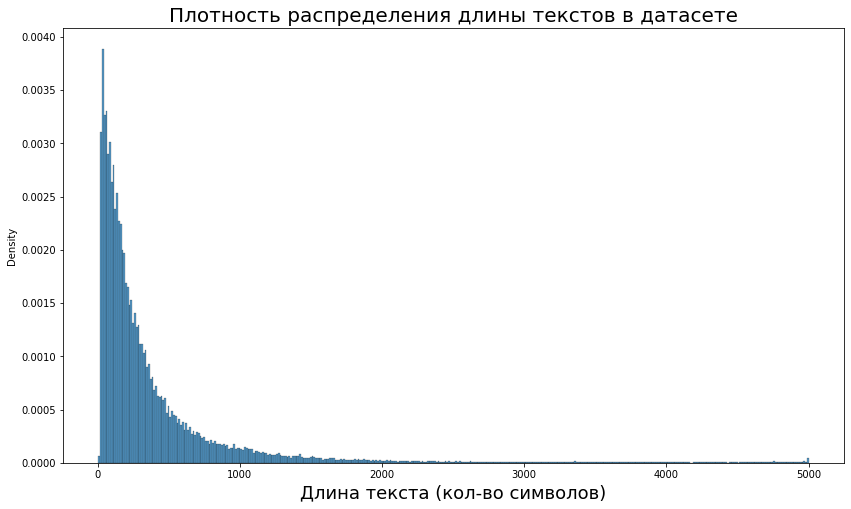

In [174]:
plt.figure(figsize=(14,8))
sns.histplot(df['text'].apply(len), stat='density')
plt.title('Плотность распределения длины текстов в датасете', fontsize=20)
plt.xlabel('Длина текста (кол-во символов)', fontsize=18);

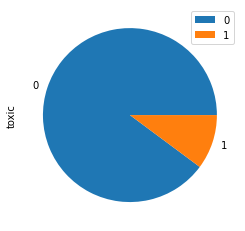

In [69]:
df['toxic'].value_counts(normalize=True).plot(kind='pie', legend=True);

Воспользуемся генерацией облака слов с помощью библиотеки `WordCloud`.

В категориях все тексты, токсичные тексты, нетоксичные тексты возьмем по 100 самых популярных слов и визуализируем их.

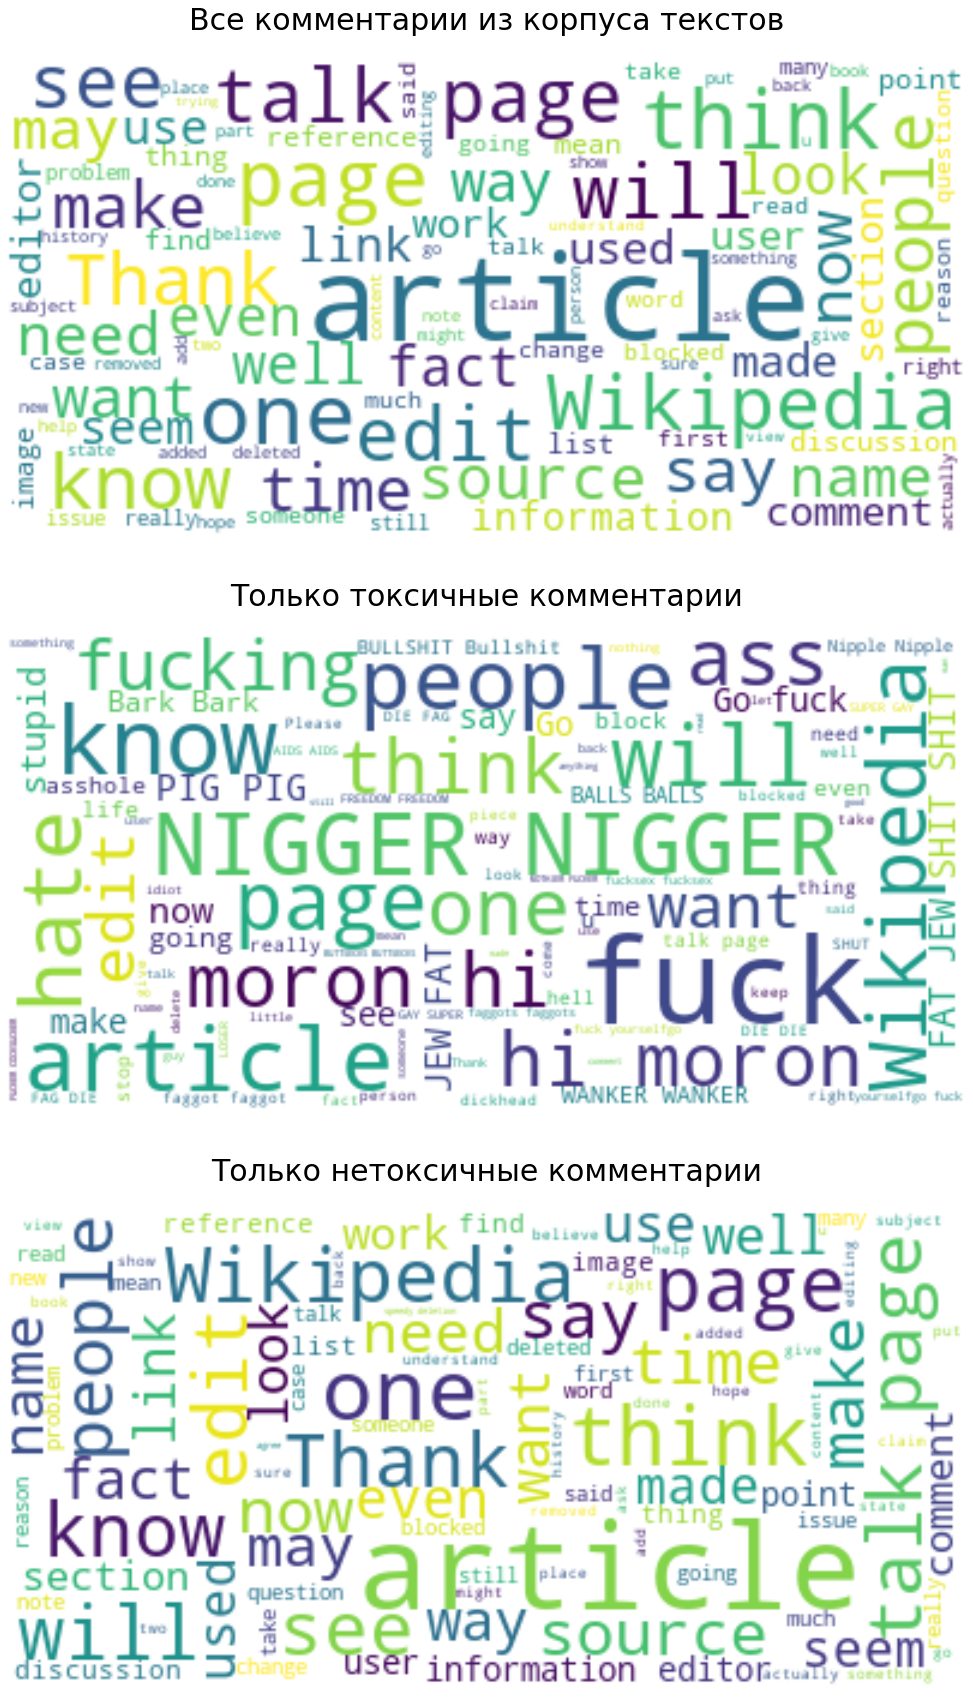

In [22]:
df_toxic = df.loc[df['toxic'] == 1, 'text']
df_non_toxic = df.loc[df['toxic'] == 0, 'text']

full_str = " ".join(text for text in df['text'])
toxic_str = " ".join(text for text in df_toxic)
non_toxic_str = " ".join(text for text in df_non_toxic)

fig, ax = plt.subplots(3, 1, figsize=(30,30))
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(full_str)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(toxic_str)
wordcloud_non_toxic = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(non_toxic_str)


ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('Все комментарии из корпуса текстов', fontsize=30, y=1.05)
ax[0].axis('off')
ax[1].imshow(wordcloud_toxic, interpolation='bilinear')
ax[1].set_title('Только токсичные комментарии',fontsize=30, y=1.05)
ax[1].axis('off')
ax[2].imshow(wordcloud_non_toxic, interpolation='bilinear')
ax[2].set_title('Только нетоксичные комментарии',fontsize=30, y=1.05)
ax[2].axis('off');

#### Вывод

1. В наших данных представлено 159571 наблюдений, каждое из которых имеет текст (комментарий с сайта магазина "Викишоп") и целевую метку, описывающую токсичность текста (1 - токсичный, 0 - нетоксичный).
2. Средняя длина текста 394 символа, медиана при этом 205 символов - сказывается наличие выбросов (самый длинный комментарий - 5000 символов).
3. В данных имеет место дисбаланс классов - токсичных комментариев всего 10%
3. Визуализировали плотность распределения длины текстов: ожидаемо увидели, что большая часть комментариев короткие, почти все комментарии длиной до 1000 символов. Однако распределение имеет длинный хвост вправо до 5000 символов. Видимо 5000 это техническое ограничение окошка для комментария на веб-сайте.
4. Визуализировали самые популярные слова из 3-х облаков слов: 
    1. Для всех комментариев: *Wikipedia, will, know, article, one, think...*
    2. Для токсичных комментариев: *nigger, fuck, shit, talk, article, moron, hate...*
    3. Для нетоксичных комментариев: *Wikipedia, article, know, thank, page, question...*

### Разделение на выборки


* В связи с тем, что мы будем использовать тяжеловесный BERT, придется случайным образом уменьшить размер нашего датасета, чтобы вычисление эмбеддингов заняло какое-то разумное время;
* В связи с сильным дисбалансом классов перед обучением будем выполнять downsampling;
* Принципиально важно сделать это только с обучающей выборкой, **поэтому сперва выполним разделение всех данных на обучающую и тестовую выборки**, под тест отведем 10% от уменьшенного датасета. 

In [26]:
df_mini = df.sample(frac=0.2, random_state=RS)
df_mini.shape

(31914, 2)

In [27]:
X = df_mini['text']
y = df_mini['toxic']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, 
                                                    shuffle=True, random_state=RS)
X_train.shape, X_test.shape

((28722,), (3192,))

In [30]:
y_train.value_counts(normalize=True)

0    0.897361
1    0.102639
Name: toxic, dtype: float64

### Downsampling

Для более качественного обучения моделей классификации выполним *dowwnsampling* **обучающей выборки**, уменьшив количество нетоксичных текстов до количества токсичных (получим соотношение классов 1:1).

In [31]:
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=RS)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=RS)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=RS)
    
    return X_downsampled, y_downsampled

Доля остающихся нетоксичных комментариев 0.11 - выбрана таким образом, чтобы достичь соотношения классов 1:1.

In [32]:
X_train, y_train = downsample(X_train, y_train, 0.11)
X_train.shape, y_train.shape

((5783,), (5783,))

In [33]:
y_train.value_counts(normalize=True)

1    0.50977
0    0.49023
Name: toxic, dtype: float64

Отлично, разбили почти идеально. Теперь фичи снова соединим, чтобы преобразовать их в эмбеддинги.

In [35]:
X = pd.concat([X_train, X_test])
X.shape

(8975,)

Мы объединили фичи трейна и теста, но после создания эмбеддингов нам понадобится обратно разделить их в том же порядке, поэтому запомним, что **первые 5783 наблюдения - это трейн**.

### Токенизация текстов

Для токенизации наших комментариев, а также для создания эмбеддингов мы будем использовать модель BERT, специально обученную для задач классификации текстов по токсичности. Модель называется `toxic-bert` и создана командой **The Conversation AI**, исследовательской инициативой компаний Jigsaw и Google. Модель создавалась для поддержания здоровой атмосферы в онлайн-беседах и обучалась на корпусе английской википедии, а также на комментариях пользователей из интернета.

[Ссылка на репозиторий unitary/toxic-bert](https://huggingface.co/unitary/toxic-bert)

У модели BERT есть ограничение длины текста в 512 символов, поэтому обрежем более длинные строки до этого значения. Передадим соответствующие аргументы в метод `.encode`.

In [16]:
%%time
tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = X.apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=512, 
                               add_special_tokens=True))
tokenized.shape

CPU times: total: 11.8 s
Wall time: 14.4 s


(8975,)

In [17]:
max_len = max(tokenized.apply(len))
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
padded.shape

(8975, 512)

### Создание эмбеддингов

Для создания эмбеддингов будем использовать нашу сбалансированную обучающую выборку + фичи тестовой выборки (57509 текстов, длиной по 512 токенов).
Используем всё ту же предобученную на токсичных текстах модель.

In [114]:
model = AutoModel.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Так как эмбеддинги на локальной машине создаются довольно долго (около 4-х часов), для удобства перезапуска тетрадки и отлаживания кода архив с дампом однажды посчитанных эмбеддингов загружен на облачное хранилище, откуда и подгружается при наличии интернета и доступности ссылки.

В следующей ячейке этот подход реализован в виде ветвящегося кода:
* Если ссылка актвна (код ответа 200), забираем по ней npz-файл (26 Мб), это архив numpy, он имеет структуру словаря, поэтому для дальнейшей работы его необходимо распарсить в список массивов;
    * После загрузки файла проверяем количество батчей, количество эмбеддингов в батче и длину каждого эмбеддинга.
* Если ссылка недоступна (код ответа 404), тогда создаём эмбеддинги заново (45 батчей по 200 текстов длиной в 512 токена каждый) и по завершении сохраняем их на диск в файл `embeddings_for_toxic_comments`
* В случае других ошибок возвращается сообщение с просьбой проверить интернет-соединение.

Наш дополненный нулями набор токенов содержит внутри 2 комплекта фичей:
* Первые 5783 наблюдения из обучающей выборки;
* Оставшиеся из тестовой.

In [18]:
%%time

response = requests.get('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/9XTUSeWnAW2PEA')

if response.status_code == 200:
    print("Npz-file with embeddings found, unpacking in progress.\n")
    embeddings_zip = np.load(BytesIO(response.content)) 
    embeddings = []
    for key, arr in embeddings_zip.items():
        embeddings.append(arr)
    print('Проверим размерность загруженного файла с эмбеддингами:')
    print("""
    Количество батчей: {0}
    Количество текстов в одном батче: {1}
    Длина эмбеддинга одного текста: {2}\n""".format(len(embeddings),
                                                  len(embeddings[0]),
                                                  len(embeddings[0][0])
                                                  )
         )
    
elif response.status_code == 404:
    print("The file with embeddings was not found by the URL, proceed to create embeddings again.")
    batch_size = 200
    embeddings = []
    for batch_number in notebook.tqdm(range(padded.shape[0] // batch_size)):
            start = batch_size*batch_number
            end = batch_size*(batch_number + 1)

            batch = torch.LongTensor(padded[start:end]) 
            attention_mask_batch = torch.LongTensor(attention_mask[start:end])

            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
    # special "crutch" for values not included in batches
    last_batch = torch.LongTensor(padded[-(padded.shape[0] % batch_size):])
    attention_mask_last_batch = torch.LongTensor(attention_mask[-(padded.shape[0] % batch_size):])
    with torch.no_grad():
        batch_embeddings = model(last_batch, attention_mask=attention_mask_last_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
    np.savez("embeddings_for_toxic_comments", *embeddings)

else:
    print('Check your internet-connection!')

Npz-file with embeddings found, unpacking in progress.

Проверим размерность загруженного файла с эмбеддингами:

    Количество батчей: 45
    Количество текстов в одном батче: 200
    Длина эмбеддинга одного текста: 768

CPU times: total: 266 ms
Wall time: 3.09 s


### Разделение фичей после создания эмбеддингов

Складываем все эмбеддинги в один массив, после чего раздялем его по индексам обратно на обучающую и тестовую выборки.

In [36]:
X = np.concatenate(embeddings)
X.shape

(8975, 768)

In [37]:
X_train, X_test = X[:5783], X[5783:]
X_train.shape, X_test.shape

((5783, 768), (3192, 768))

In [38]:
y_train = y_train.values
y_test = y_test.values
y_train.shape, y_test.shape

((5783,), (3192,))

## Обучение

Обучение моделей будем проводить с помощью фреймворка **Optuna**, задача которого оптимальным образом подбирать гиперпараметры для любых моделей.

* Для контроля обобщающей способности моделей и переобучения используем кросс-валидацию с делением обучающей выборки на 5 фолдов;
* Результаты работы каждой модели сохраняем в датафрейм, индексами которого являются метрики F1 (среднее гармонической точности и полноты). Здесь сохраняем сразу и F1 с обучающей выборки (с кросс-валидации) и с тестовой выборки.

In [127]:
kf = KFold(n_splits=5, shuffle=True, random_state=RS)

In [128]:
results = pd.DataFrame(index=['f1_train', 'f1_test'])

Функция `optuna_search` принимает на вход функцию, которую необходимо оптимизировать, количество испытаний в исследовании и имя исследования. Внутри:
1. Создаем экземпляр класса `study` из модуля Optuna, задаём направление оптимизации функции (так как у нас F1, то её максимизируем для повышения качества модели);
2. Запускам собственно процесс оптимизации созданного исследования (`study`) с заданным количеством испытаний (`trial`).

In [129]:
def optuna_search(obj_func, n_trials, study_name='unnamed'):
    study = optuna.create_study(direction='maximize', study_name=study_name)
    study.optimize(obj_func, n_trials=n_trials)
    
    print(f"\tBest value (F1-score): {study.best_value:.5f}")
    print(f"\tBest params:")

    for key, value in study.best_params.items():
        print(f"\t\t{key}: {value}")
    return study

Функция `metric_fixer` необходима для фиксации результатов в вышеописанный датафрейм `results`:
1. Принимает на вход оптимизированный объект класса `optuna.Study` и строковое имя модели, которую мы оптимизировали;
2. Из словаря берёт чистый объект модели (лог.регрессию, случайный лес или LightGBM-классификатор);
3. Инициализирует модель с параметрами, которые были выбраны как наилучшие в процессе исследования Оптуной;
4. Обучает модель на полной обучающей выборке;
5. Считает метрику качества F1 на тестовой выборке и записывает в датафрейм `results`. Туда же записывает и наилучшее значение F1, полученной Оптуной в процессе обучения.

In [130]:
def metric_fixer(study: optuna.Study, model):
    models_dict = {
        'lr': LogisticRegression(random_state=RS),
        'rf': RandomForestClassifier(),
        'lgbm': LGBMClassifier()
    } 
    
    model = models_dict.get(model).set_params(**study.best_params)
    model.fit(X_train, y_train)
    
    score_train = study.best_value
    score_test = f1_score(y_test, model.predict(X_test))
    
    results[type(model).__name__] = [score_train, score_test]
    return results

### Baseline

В качестве базовой точки для обучения, а также проверки на адекватность наших следующих моделей используем думми-классификатор из библиотеки `sklearn`.

In [131]:
dummy = DummyClassifier(strategy='stratified', random_state=RS)
dummy.fit(X_train, y_train)
pred = dummy.predict(X_test)
score_train = f1_score(y_train, dummy.predict(X_train))
score_test = f1_score(y_test, pred)
results['DummyClassifier'] = [score_train, score_test]
print('F1 метрика для думми-классификатора: {0}'.format(round(score_test, 5)))


F1 метрика для думми-классификатора: 0.16788


### LogisticRegression

In [132]:
def objective_lr(trial: optuna.Trial):
    logreg_c = trial.suggest_float('C', 1e-10, 1e10, log=True)
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
    model = LogisticRegression(C=logreg_c)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring="f1")
    return np.mean(scores['test_score'])

In [133]:
%%time
lr_study = optuna_search(objective_lr, 10, 'LogReg')

[I 2022-06-18 22:07:11,664] A new study created in memory with name: LogReg
[I 2022-06-18 22:07:14,097] Trial 0 finished with value: 0.9731767498028973 and parameters: {'C': 2129927457.7558818, 'tol': 1.5158837783963949e-05}. Best is trial 0 with value: 0.9731767498028973.
[I 2022-06-18 22:07:14,646] Trial 1 finished with value: 0.6752564865977588 and parameters: {'C': 3.9421201601016885e-09, 'tol': 0.0006824696631138157}. Best is trial 0 with value: 0.9731767498028973.
[I 2022-06-18 22:07:16,997] Trial 2 finished with value: 0.9731841569830646 and parameters: {'C': 80076945.71955462, 'tol': 1.6371557400087986e-05}. Best is trial 2 with value: 0.9731841569830646.
[I 2022-06-18 22:07:17,514] Trial 3 finished with value: 0.9814028199977359 and parameters: {'C': 2.0067086542765826e-05, 'tol': 0.002029961742336601}. Best is trial 3 with value: 0.9814028199977359.
[I 2022-06-18 22:07:19,857] Trial 4 finished with value: 0.9740313084584209 and parameters: {'C': 2861695.565975569, 'tol': 0.00

	Best value (F1-score): 0.98140
	Best params:
		C: 2.0067086542765826e-05
		tol: 0.002029961742336601
CPU times: total: 1min 23s
Wall time: 15 s


In [134]:
%%time
metric_fixer(lr_study, 'lr')

CPU times: total: 297 ms
Wall time: 154 ms


,DummyClassifier,LogisticRegression
f1_train,0.509797,0.981403
f1_test,0.167876,0.889796


### Random Forest

In [135]:
def objective_rf(trial: optuna.Trial):
    params = {
    'random_state': RS,
    'n_estimators': trial.suggest_int('n_estimators', 10, 500),
    'max_depth': trial.suggest_int('max_depth', 1, 32, log=True),
    'max_features': trial.suggest_int('max_features', 3, 27),
#     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 9, step=3),
#     'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
#     'criterion': trial.suggest_categorical('criterion', ["gini", "entropy"])
          }
    model = RandomForestClassifier(**params)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring="f1", n_jobs=-1)
    return np.mean(scores['test_score'])

In [136]:
%%time
rf_study = optuna_search(objective_rf, 10, 'RandomForest')

[I 2022-06-18 22:08:11,813] A new study created in memory with name: RandomForest
[I 2022-06-18 22:08:15,267] Trial 0 finished with value: 0.9781104418863384 and parameters: {'n_estimators': 174, 'max_depth': 1, 'max_features': 7}. Best is trial 0 with value: 0.9781104418863384.
[I 2022-06-18 22:09:04,985] Trial 1 finished with value: 0.9805643141956955 and parameters: {'n_estimators': 438, 'max_depth': 19, 'max_features': 24}. Best is trial 1 with value: 0.9805643141956955.
[I 2022-06-18 22:09:12,836] Trial 2 finished with value: 0.9801835789900085 and parameters: {'n_estimators': 437, 'max_depth': 1, 'max_features': 27}. Best is trial 1 with value: 0.9805643141956955.
[I 2022-06-18 22:09:16,464] Trial 3 finished with value: 0.9795383393336785 and parameters: {'n_estimators': 329, 'max_depth': 1, 'max_features': 12}. Best is trial 1 with value: 0.9805643141956955.
[I 2022-06-18 22:09:16,741] Trial 4 finished with value: 0.9789935271521266 and parameters: {'n_estimators': 12, 'max_dept

	Best value (F1-score): 0.98131
	Best params:
		n_estimators: 475
		max_depth: 2
		max_features: 25
CPU times: total: 422 ms
Wall time: 1min 52s


In [147]:
%%time
metric_fixer(rf_study, 'rf')

CPU times: total: 10.4 s
Wall time: 10.5 s


,DummyClassifier,LogisticRegression,LGBMClassifier,RandomForestClassifier
f1_train,0.509797,0.981403,0.981209,0.981308
f1_test,0.167876,0.889796,0.907331,0.873164


### LightGBMClassifier

In [143]:
def objective_lgbm(trial: optuna.Trial):
    params = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [3000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 10000, step=100),
#         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         "bagging_fraction": trial.suggest_float(
#             "bagging_fraction", 0.2, 0.95, step=0.1),
#         "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         "feature_fraction": trial.suggest_float(
#             "feature_fraction", 0.2, 0.95, step=0.1),
#         "max_bin": trial.suggest_int("max_bin", 30, 300)
    }
    model = LGBMClassifier(**params)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring="f1", n_jobs=None)
    return np.mean(scores['test_score'])

In [144]:
%%time
lgbm_study = optuna_search(objective_lgbm, 10, 'LGBM')

[I 2022-06-18 22:13:59,773] A new study created in memory with name: LGBM


[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510
[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510
[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510
[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510
[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510


[I 2022-06-18 22:14:53,842] Trial 0 finished with value: 0.9812093662687609 and parameters: {'n_estimators': 3000, 'learning_rate': 0.1982157675030372, 'num_leaves': 120, 'max_depth': 10, 'min_data_in_leaf': 510}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210


[I 2022-06-18 22:14:56,028] Trial 1 finished with value: 0.6752564865977588 and parameters: {'n_estimators': 3000, 'learning_rate': 0.12534780326322964, 'num_leaves': 2980, 'max_depth': 3, 'min_data_in_leaf': 8210}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710


[I 2022-06-18 22:14:58,163] Trial 2 finished with value: 0.6752564865977588 and parameters: {'n_estimators': 3000, 'learning_rate': 0.18952162688664606, 'num_leaves': 920, 'max_depth': 10, 'min_data_in_leaf': 5710}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=1910, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1910
[LightGBM] [Warning] min_data_in_leaf is set=1910, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1910
[LightGBM] [Warning] min_data_in_leaf is set=1910, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1910
[LightGBM] [Warning] min_data_in_leaf is set=1910, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1910
[LightGBM] [Warning] min_data_in_leaf is set=1910, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1910


[I 2022-06-18 22:15:50,283] Trial 3 finished with value: 0.9794841971145315 and parameters: {'n_estimators': 3000, 'learning_rate': 0.04371122020059503, 'num_leaves': 940, 'max_depth': 10, 'min_data_in_leaf': 1910}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=4410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4410
[LightGBM] [Warning] min_data_in_leaf is set=4410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4410
[LightGBM] [Warning] min_data_in_leaf is set=4410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4410
[LightGBM] [Warning] min_data_in_leaf is set=4410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4410
[LightGBM] [Warning] min_data_in_leaf is set=4410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4410


[I 2022-06-18 22:15:52,506] Trial 4 finished with value: 0.6752564865977588 and parameters: {'n_estimators': 3000, 'learning_rate': 0.20633926157353577, 'num_leaves': 2700, 'max_depth': 6, 'min_data_in_leaf': 4410}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=9610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9610
[LightGBM] [Warning] min_data_in_leaf is set=9610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9610
[LightGBM] [Warning] min_data_in_leaf is set=9610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9610
[LightGBM] [Warning] min_data_in_leaf is set=9610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9610
[LightGBM] [Warning] min_data_in_leaf is set=9610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9610


[I 2022-06-18 22:15:54,634] Trial 5 finished with value: 0.6752564865977588 and parameters: {'n_estimators': 3000, 'learning_rate': 0.17394631359642979, 'num_leaves': 1480, 'max_depth': 8, 'min_data_in_leaf': 9610}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=6810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6810
[LightGBM] [Warning] min_data_in_leaf is set=6810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6810
[LightGBM] [Warning] min_data_in_leaf is set=6810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6810
[LightGBM] [Warning] min_data_in_leaf is set=6810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6810
[LightGBM] [Warning] min_data_in_leaf is set=6810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6810


[I 2022-06-18 22:15:56,754] Trial 6 finished with value: 0.6752564865977588 and parameters: {'n_estimators': 3000, 'learning_rate': 0.2510637211122823, 'num_leaves': 940, 'max_depth': 5, 'min_data_in_leaf': 6810}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=1410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1410
[LightGBM] [Warning] min_data_in_leaf is set=1410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1410
[LightGBM] [Warning] min_data_in_leaf is set=1410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1410
[LightGBM] [Warning] min_data_in_leaf is set=1410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1410
[LightGBM] [Warning] min_data_in_leaf is set=1410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1410


[I 2022-06-18 22:17:32,892] Trial 7 finished with value: 0.9788319686101307 and parameters: {'n_estimators': 3000, 'learning_rate': 0.15456652456695424, 'num_leaves': 2640, 'max_depth': 11, 'min_data_in_leaf': 1410}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210


[I 2022-06-18 22:17:35,781] Trial 8 finished with value: 0.6752564865977588 and parameters: {'n_estimators': 3000, 'learning_rate': 0.08826492207489092, 'num_leaves': 2820, 'max_depth': 5, 'min_data_in_leaf': 8210}. Best is trial 0 with value: 0.9812093662687609.


[LightGBM] [Warning] min_data_in_leaf is set=7610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7610
[LightGBM] [Warning] min_data_in_leaf is set=7610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7610
[LightGBM] [Warning] min_data_in_leaf is set=7610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7610
[LightGBM] [Warning] min_data_in_leaf is set=7610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7610
[LightGBM] [Warning] min_data_in_leaf is set=7610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7610


[I 2022-06-18 22:17:38,437] Trial 9 finished with value: 0.6752564865977588 and parameters: {'n_estimators': 3000, 'learning_rate': 0.2770391613798421, 'num_leaves': 2220, 'max_depth': 6, 'min_data_in_leaf': 7610}. Best is trial 0 with value: 0.9812093662687609.


	Best value (F1-score): 0.98121
	Best params:
		n_estimators: 3000
		learning_rate: 0.1982157675030372
		num_leaves: 120
		max_depth: 10
		min_data_in_leaf: 510
CPU times: total: 23min 35s
Wall time: 3min 38s


In [148]:
%%time
metric_fixer(lgbm_study, 'lgbm')

[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510
CPU times: total: 1min 30s
Wall time: 12.4 s


,DummyClassifier,LogisticRegression,LGBMClassifier,RandomForestClassifier
f1_train,0.509797,0.981403,0.981209,0.981308
f1_test,0.167876,0.889796,0.907331,0.873164


## Анализ результатов

In [149]:
round(results, 5)

,DummyClassifier,LogisticRegression,LGBMClassifier,RandomForestClassifier
f1_train,0.50980,0.9814,0.98121,0.98131
f1_test,0.16788,0.8898,0.90733,0.87316


* Все модели на обучении показали себя очень хорошо, **метрика F1 не опускалась ниже 0.98 на обучащей выборке**;
* Вероятнее всего это связано с хорошей подготовкой данных перед обучением, включая использование очень хорошей и специфичной к токсичности предобученной модели от команды **Conversation AI**;
* Учитывая скорость обучения и скорость инференса, мы рекомендуем заказчику использовать логистическую регрессию. Она уступает модели бустинга лишь в 3-м знаке после запятой, зато работает значительно быстрее;
    * К тому же она по итогам обучения показала себя лучше случайного леса, хоть и немножко хуже бустинга.
* К сожалению, из-за специфики работы BERT'а невозможно после обучения визуализировать наиболее важные слова/фразы/предложения, на которые опирались модели в решении задачи классификации.

## Выводы

В этом проекте мы использовали датасет из 159 тысяч текстовых комментариев из магазина "Викишоп", размеченных по токсичности (1/0) чтобы обучить модель классификации. В процессе работы:
1. Ознакомились с данными и визуализировали наиболее популярные слова из всего корпуса, токсичного корпуса и нетоксичного корпуса;
1. Так как для векторизации текстов использовалась модель BERT, из-за нехватки вычислительных ресурсов оставили только 20% от исходного датасета;
2. В связи с дисбалансом классов в данных (90/10) после разбиения на обучающую и тестовую выборку выполнили даунсемлинг обучающей выборки путем уменьшения количества нетоксичных текстов, достигнув соотношения токсичных и нетоксичных текстов 50/50 в обучающей выборке (в тестовой при этом осталось исходное 90/10);
4. Токенизацию и векторизацию текстов выполнили с помощью предобученной на большом корпусе модифицированной BERT-модели (*unitary/toxic-bert* в репозитории HuggingFace). Эта модель была обучена при поддержке Google и высокоспецифична к выявлению токсичность в онлайн-беседах;
5. В данном проекте мы обучали классификации 3 модели из разных классов: логистическая регрессия, случайный лес и бустинг LightGBM. Все модели достигли прекрасных показателей метрики **F1 при обучении - около 0.98 на обучающей выборке**.
6. Учитывая такие факторы, как скорость обучения и предсказания модели, а также её сложность, **мы рекомендуем заказчику ("Викишоп") использовать в данном случае логистическую регрессию**, с метрикой качества F1=0.889 на тестовой выборке.